In [1]:
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
%matplotlib inline


In [2]:
# do that: conda install -c conda-forge umap-learn
import umap

In [3]:
# set default style of figures
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [4]:
#opening database and visualization
crops=pd.read_csv('./data/Production_Crops_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
crops.head(5)

grouped_yield_for_pca=(crops.query('`Element Code` == 5419') #by yield
        .query('`Year Code` == 2015') 
        .query('`Item Code` >1000') #grouped crops
        .pivot(index='Area',columns='Item',values='Value')
        .fillna(value=0)
        .reset_index()
          )
grouped_yield_for_pca.head()

fertilizer_area=pd.read_csv('./data/Environment_Fertilizers_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
fertilizer_area.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2002,2002,kg/ha,3.02,Fc


In [5]:
# dataset for umap
yield_data = grouped_yield_for_pca.drop('Area',axis=1).values

### Normalization


In [6]:
#Normalization 
from sklearn import preprocessing

x = yield_data
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
yield_data = pd.DataFrame(x_scaled)

## Reducing to 2 dim (further there is the reduction to 1 dimension (maybe more congruent))

In [7]:
#extract fertilizer use for 2015 (error in name)
fertilizer_area_2016=(fertilizer_area.query('`Item Code` == (3102)')
    .query('`Year Code` == 2015')
    .query('`Area Code` <300')
    .sort_values('Value', ascending=False)
)

In [8]:
def ferti_class(x, L): #associate a color to each bin of fertilizer
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

In [9]:
def ferti_class2(x): #associate a color to each bin of fertilizer
    if x<50 :
        return 'low'
    elif 50<=x<150:
        return 'medium'
    else:
        return 'high'

In [10]:
reducer = umap.UMAP(random_state=1)
embedding = reducer.fit_transform(yield_data)
embedding2=pd.DataFrame(embedding)
embedding2=pd.merge(embedding2,grouped_yield_for_pca['Area'], left_index=True, right_index=True)
embedding2=pd.merge(embedding2,fertilizer_area_2016.loc[:,['Area','Value']],left_on='Area',right_on='Area')
embedding2['ferti_class']=embedding2.Value.apply(lambda x: ferti_class(x, embedding2.Value))
embedding2.head()

,0,1,Area,Value,ferti_class
0,1.754382,-1.529953,Afghanistan,11.71,low
1,-0.918108,1.554181,Albania,52.87,medium
2,-0.026229,0.147692,Algeria,11.83,low
3,1.562212,1.497620,Angola,4.91,low
4,3.476978,-2.466094,Antigua and Barbuda,1.70,low


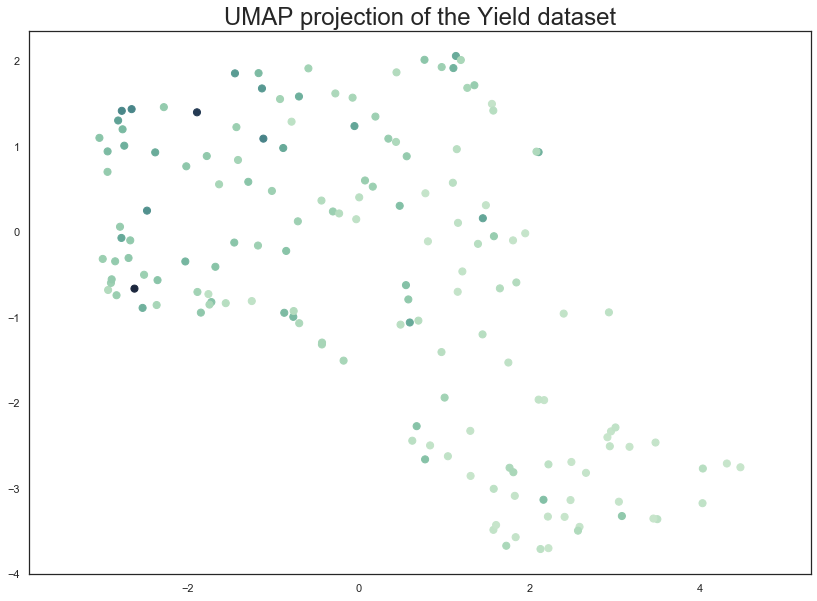

In [11]:
colors = ["green", "blue", "red"]
clarity_ranking = embedding2.Value
cmap = sns.cubehelix_palette(as_cmap=True,rot=-.4)
plt.scatter(embedding2[0], embedding2[1], c=clarity_ranking, s=50, cmap=cmap)
#plt.scatter(embedding2[0], embedding2[1], c=[sns.xkcd_palette(colors)[x] for x in embedding2.ferti_class.values])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Yield dataset', fontsize=24);

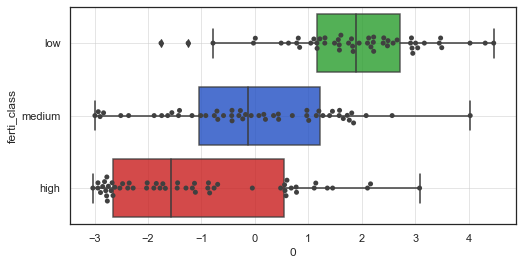

In [12]:
#Box plot x axis
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
#cmap = sns.cubehelix_palette(rot=-.4)
ax = sns.boxplot(x=embedding2[0], y='ferti_class', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[0], y='ferti_class', data=embedding2, color=".25")
ax.grid(alpha=0.5)

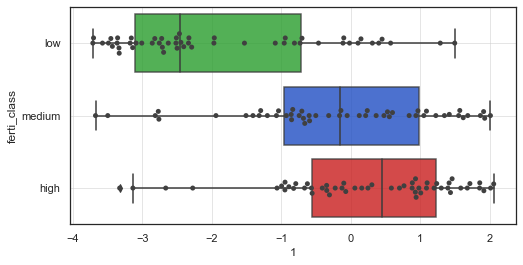

In [13]:
#Box plot y axis
fig = plt.figure(figsize = (8,4))
#sns.palplot(sns.cubehelix_palette(3))
colors = ["green", "blue", "red"]
ax = sns.boxplot(x=embedding2[1], y='ferti_class', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[1], y='ferti_class', data=embedding2, color=".25")
ax.grid(alpha=0.5)

### A function doing all above for each year

In [14]:
# Creation of a function doing the umap (works also for only 1 dimension end)
def umap_year(year, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .pivot(index='Area',columns='Item',values='Value')
            .fillna(value=0)
            .reset_index()
              )
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values # To perform the umap, we need to select only the features
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)
    embedding2=pd.merge(embedding2,yield_for_merge['Area'], left_index=True, right_index=True)
    
    umap_fertilizer=(fertilizer_area
                    .query('Year == @year')
                    .query('`Area Code` <300')
                    .query('`Item Code` == (3102)')
                    .loc[:,['Area','Value']]
                    )
    embedding2=pd.merge(embedding2,umap_fertilizer,left_on='Area',right_on='Area')
    embedding2[0]=embedding2[0]/max(embedding2[0])
    embedding2['Value']=embedding2['Value']/max(embedding2['Value'])
    embedding2['ferti_class']=embedding2.Value.apply(lambda x: ferti_class(x, embedding2.Value))
    
    coef = np.polyfit(embedding2[0],embedding2.Value,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

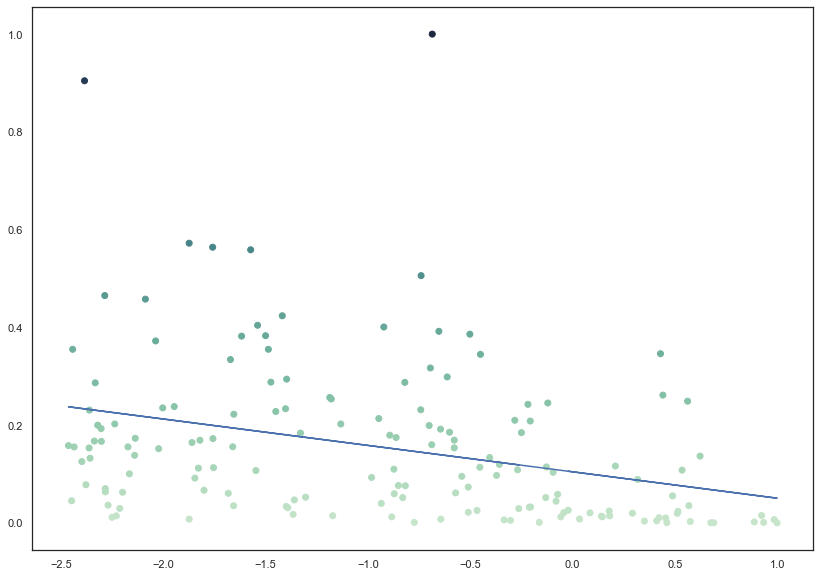

[-0.05400717  0.10455215]


In [15]:
#Visualization for year 2015
vis_2015=umap_year(2015)
embedding2=vis_2015[1]
coef = vis_2015[2]
poly1d_fn = np.poly1d(coef)
clarity_ranking = embedding2.Value
cmap = sns.cubehelix_palette(as_cmap=True,rot=-.4)
plt.scatter(embedding2[0], embedding2.Value,c=clarity_ranking, cmap=cmap)
plt.plot(embedding2[0], poly1d_fn(embedding2[0]))
plt.show()
print(coef)

In [16]:
# umap for all years available in the fertilizer dataset (the more restrictive dataset)
mean=[]
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    print(year)
    adding=umap_year(year)
    mean.append([adding[0],adding[2][0]])
mean=pd.DataFrame(mean)

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


Text(0.5, 1.0, 'Evolution of linear regression (fertilizer/axe0) over the year')

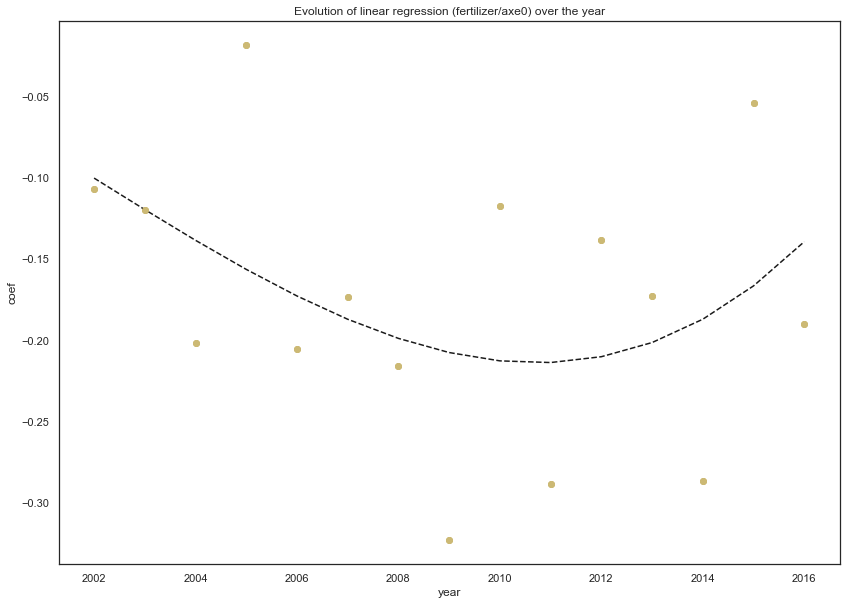

In [17]:
# look at coef over the years
coef = np.polyfit(mean[0],mean[1],3) #test regression dim 3 ...
poly1d_fn = np.poly1d(coef)
plt.plot(mean[0],mean[1], 'yo',mean[0], poly1d_fn(mean[0]), '--k')
plt.plot(mean[0],mean[1], 'yo')
plt.xlabel('year')
plt.ylabel('coef')
plt.title('Evolution of linear regression (fertilizer/axe0) over the year')

I think we can't conclude anything on these results as points are very distant, we could add the regression error to confirm


## Test of dimensionality reduction to 1 dimension

Because if we want to have only 1 criteria to rank the argricultural system of each country, is reducing to 2 dimensions cungruent ?

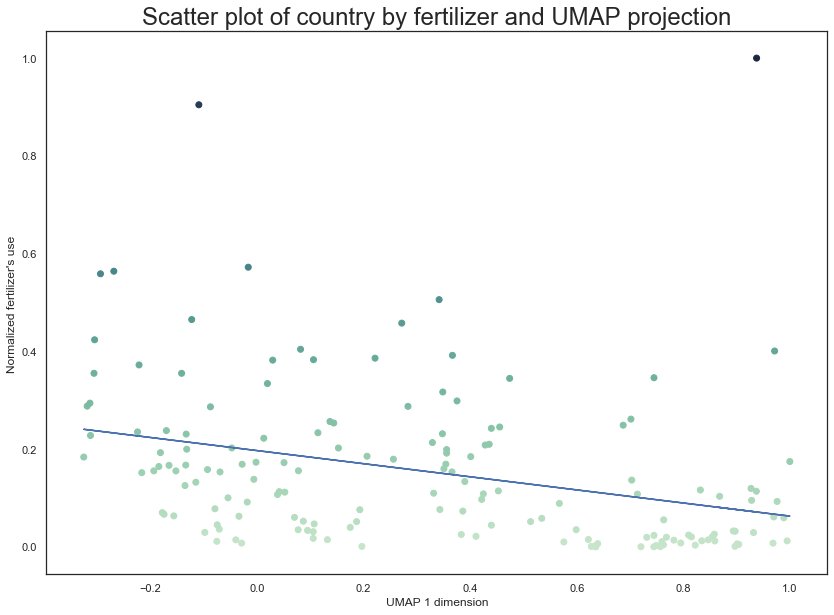

[-0.13403769  0.19703271]


In [18]:
#Visualization for year 2015

vis_2015=umap_year(2015,1)

embedding2=vis_2015[1] 
coef = vis_2015[2]
poly1d_fn = np.poly1d(coef)
clarity_ranking = embedding2.Value

cmap = sns.cubehelix_palette(as_cmap=True,rot=-.4)
plt.scatter(embedding2[0], embedding2.Value,c=clarity_ranking, cmap=cmap)
plt.plot(embedding2[0], poly1d_fn(embedding2[0]))
plt.gca().set_aspect('auto', 'datalim')
plt.title('Scatter plot of country by fertilizer and UMAP projection', fontsize=24);
plt.xlabel("UMAP 1 dimension")
plt.ylabel("Normalized fertilizer's use ")
plt.show()
print(coef)

As we can see, fertilizer use tend to increase on the left (umap has surely rank the more efficent country in term of yield on the left)

2 outliers are present and coincide with the 2 highest values. We need to take a deeper look at those points :

In [19]:
# looking at countries names
embedding2.sort_values(by='Value',ascending=False).head(2)

,0,Area,Value,ferti_class
89,0.937605,Malta,1.000000,high
47,-0.109107,Egypt,0.904547,high


In [20]:
# Looking at yield for these countries
grouped_yield_for_pca.loc[grouped_yield_for_pca.Area.isin(['Malta','Egypt'])]


Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fruit Primary,"Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
69,Egypt,66242.0,71177.0,245152.0,67937.0,235700.0,29594.0,274188.0,59398.0,244981.0
132,Malta,47135.0,47135.0,139176.0,41760.0,53245.0,27828.0,114526.0,0.0,145352.0


Firstly, Egypt (which is the black point on the left) has higher values of yield in each field compared to Malta, we can thus confirm that more efficient countries are countries with the lowest score)
We can notice that malta has a zero value : is it a missing value or it is due to the fact that maybe they don't grow treenut on the island ?
Do we have the same issue on other data ?

Update : i took a look at fao dataset online and 0 values are missing value

In [21]:
#look at how many countries have 0 values
miss_data=pd.DataFrame(columns=grouped_yield_for_pca.columns)
for x in grouped_yield_for_pca.columns :
    miss_data = pd.concat([miss_data, grouped_yield_for_pca[grouped_yield_for_pca[x]==0]])
n_miss=len(miss_data.Area.unique())
n_tot=len(grouped_yield_for_pca.Area)
print('There is %d countries with 0 values on a total of %d countries '%(n_miss,n_tot))

There is 133 countries with 0 values on a total of 245 countries 


Nearly half of the countries have 0 values, should we remove them ?

### Repartition function of fertilizer use and analyse over the years

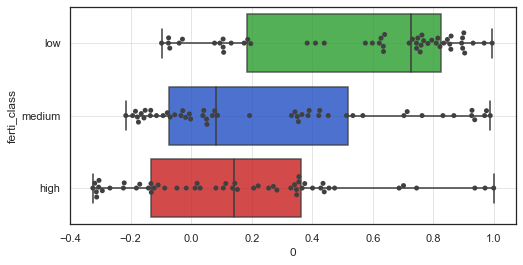

In [22]:
#Boxplot of umap 1-dim with country fertilizer's use classified in 3 different equaly sized group 
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
#cmap = sns.cubehelix_palette(rot=-.4)
ax = sns.boxplot(x=embedding2[0], y='ferti_class', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[0], y='ferti_class', data=embedding2, color=".25")
ax.grid(alpha=0.5)

In [23]:
# umap for all years available in the fertilizer dataset (the more restrictive dataset)
mean=[]
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    print(year)
    adding=umap_year(year,1)
    mean.append([adding[0],adding[2][0]])
mean=pd.DataFrame(mean)

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


Text(0.5, 1.0, 'Evolution of linear regression (fertilizer/axe0) over the year')

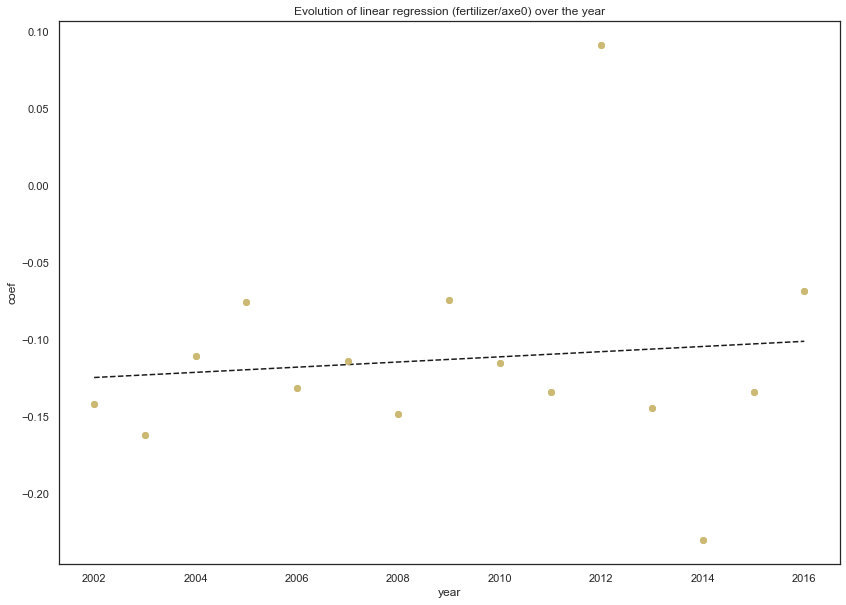

In [24]:
# look at coef over the years
coef = np.polyfit(mean[0],mean[1],1) #test regression dim 1 ...
poly1d_fn = np.poly1d(coef)
plt.plot(mean[0],mean[1], 'yo',mean[0], poly1d_fn(mean[0]), '--k')
plt.plot(mean[0],mean[1], 'yo')
plt.xlabel('year')
plt.ylabel('coef')
plt.title('Evolution of linear regression (fertilizer/axe0) over the year')


In [25]:
#Compute error of the regression
stats.linregress(mean[0],mean[1])

LinregressResult(slope=0.0016818341474317661, intercept=-3.49188040237739, rvalue=0.10868567524860939, pvalue=0.6998187241874851, stderr=0.0042663732064164355)

#### Comment :
We can see coeficient increase overtime. Thus, relation between use of fertilizer and yield is less evident.
Hovewer it might be due to a decrease of fertilizer use thus we have to analyze that ... (Victor did it)
